In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')

### Import dataset

In [30]:
df = pd.read_csv('aggregated_df_final01oct2021.csv')
#df['time']=df['time'].to_datetime(dayfirst=True).astype(int)
df[['sentiment_Extreme Fear', 'sentiment_Extreme Greed', 'sentiment_Fear','sentiment_Greed', 'sentiment_Neutral']]=df[['sentiment_Extreme Fear', 'sentiment_Extreme Greed', 'sentiment_Fear','sentiment_Greed', 'sentiment_Neutral']].fillna(0)
df=df[df['time']>'2018-02-01']


df.set_index('time', drop=True, inplace=True)
df.sort_index(inplace=True)
df=df.interpolate(method='linear')
df = df.fillna(method='bfill')

df.head()

,open_x,high_x,low_x,close_x,Basis_x,Volume_x,RSI_x,MACD_x,OnBalanceVolume_x,btc_dom,...,btc_s2f,btc_s2f_price,nlp_compound,nlp_subjectivity,nlp_polarity,sentiment_Extreme Fear,sentiment_Extreme Greed,sentiment_Fear,sentiment_Greed,sentiment_Neutral
time,,,,,,,,,,,,,,,,,,,,,
2018-02-02,9257.195166,9320.141554,7936.662436,8861.514997,11196.858121,2.609413e+06,32.744653,-1022.517744,-2.407707e+07,38.532225,...,21.972193,5123.807531,0.046026,0.301264,0.024677,1.0,0.0,0.0,0.0,0.0
2018-02-03,8866.514998,9486.004860,8215.499500,9199.979721,10991.232357,1.228396e+06,35.408121,-1060.022415,-2.284867e+07,38.753037,...,23.365578,6299.633645,0.111615,0.258558,0.029066,0.0,0.0,0.0,0.0,1.0
2018-02-04,9153.848338,9388.999999,7865.000000,8150.905001,10724.054383,1.654689e+06,31.273289,-1161.013261,-2.450336e+07,38.829241,...,20.742972,4222.645721,0.116604,0.356650,0.039908,1.0,0.0,0.0,0.0,0.0
2018-02-05,8195.343835,8381.399999,6547.500001,6944.995500,10521.304157,3.504590e+06,27.322103,-1323.104132,-2.800795e+07,39.668501,...,19.960842,3711.070004,0.137341,0.293505,0.049372,0.0,0.0,0.0,0.0,1.0
2018-02-06,6955.575000,7904.000000,5975.005000,7664.070004,10357.015135,3.466811e+06,32.775209,-1377.658226,-2.454114e+07,39.686587,...,21.724833,4932.553603,0.074743,0.273262,0.039630,0.0,0.0,1.0,0.0,0.0


In [31]:
df.info()

In [32]:
df = df['close_x']
df.head()

time
2018-02-02    8861.514997
2018-02-03    9199.979721
2018-02-04    8150.905001
2018-02-05    6944.995500
2018-02-06    7664.070004
Name: close_x, dtype: float64

### Import dataset

### EDA
- Closing price boxplot
- ACF and PACF
- Stationarity check (mean and variance)
    - ADF test
    - KSS test

D:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


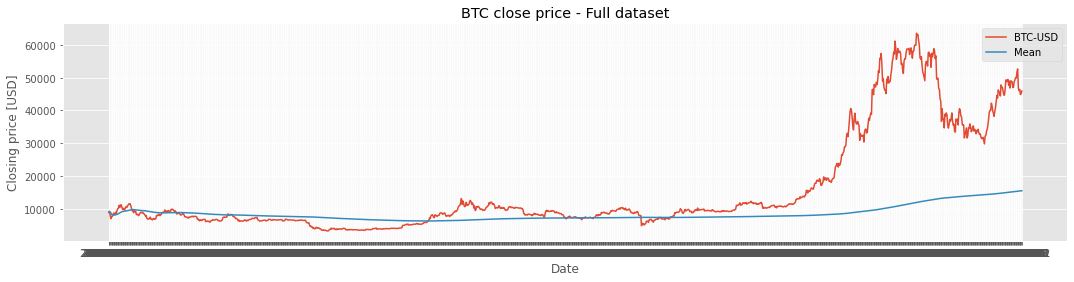

In [33]:
mean = [np.mean(df.values[:x]) for x in range(df.shape[0])]
plt.figure(figsize=(18,4))
sns.lineplot(x=df.index ,y=df.values, label='BTC-USD', ci='sd')
sns.lineplot(x=df.index, y=mean, label='Mean', ci=None)
plt.title('BTC close price - Full dataset')
plt.ylabel('Closing price [USD]')
plt.xlabel('Date')
plt.show()

From this we can see that the data is not stationary, as both the mean and the variance are increasing over time.

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


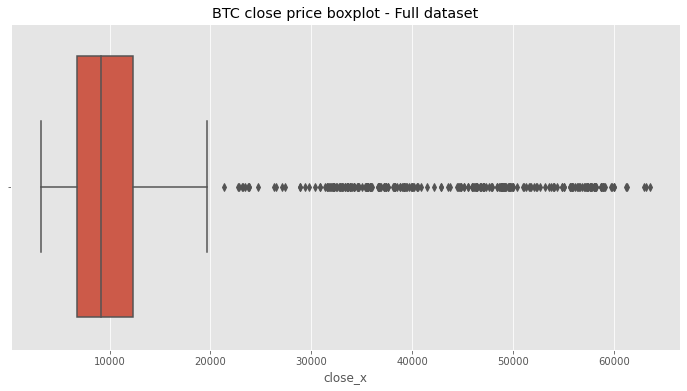

In [34]:
plt.figure(figsize=(12,6))
sns.boxplot(df)
plt.title('BTC close price boxplot - Full dataset')
plt.show()

### __Preprocessing__
- Train/test split
- Stationarity check (mean and variance)
    - Seasonal decompose of train
    - ADF test
    - KSS test
- Stationarity transformation
- LSTM data transformation

#### Train/Test split

In [38]:
# Train/Test split

# Number of periods to incluse in validation split
val_periods = 150

df_train = df[:df.shape[0]-val_periods]
df_val = df[df.shape[0]-val_periods:]

print('Train shape', df_train.shape)
print('Validation shape', df_val.shape)

Train shape (1169,)
Validation shape (150,)


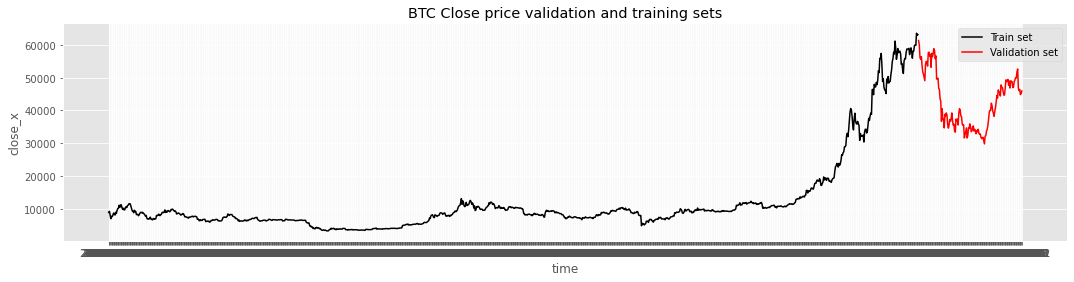

In [39]:
plt.figure(figsize=(18,4))
sns.lineplot(data=df_train, color='black', label = 'Train set', ci='sd')
sns.lineplot(data=df_val, color='red', label='Validation set', ci='sd')
plt.title('BTC Close price validation and training sets')
plt.show()

#### Stationarity check

<ipython-input-40-4bfe1d04456a>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  season = seasonal_decompose(df_train, freq=365)


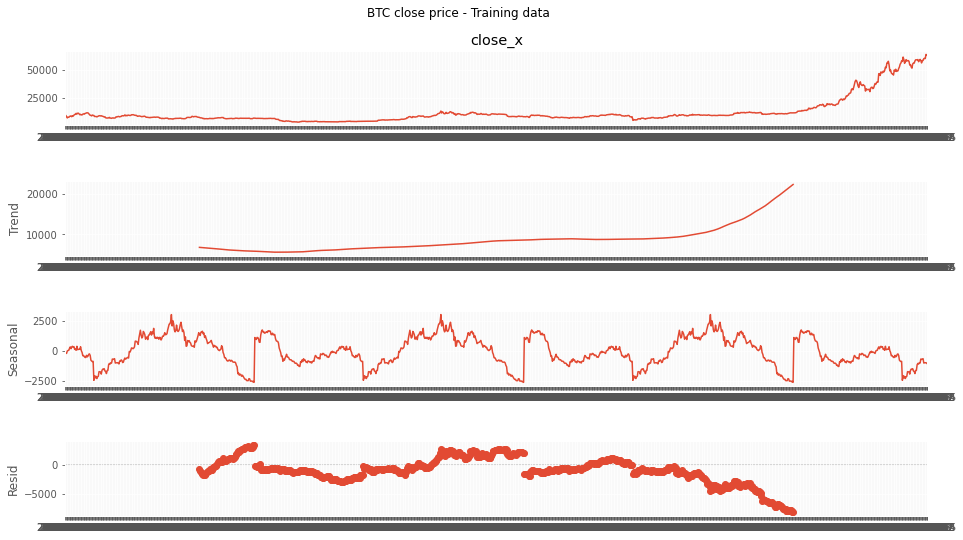

In [40]:
# chart with cycles that repeat every 365 days (1 year)
season = seasonal_decompose(df_train, freq=365)
fig = season.plot();
fig.suptitle('BTC close price - Training data')
fig.set_size_inches(16,8)

In [41]:
#Dickey Fuller Test fot Stationarity 
adfinput = adfuller(df_train)
adftest = pd.Series(adfinput[0:4], index=['Dickey Fuller Test', 'P-value',
                                          'Used Lags', 'Number of comments used'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Critical Value (%s)"%key] = value.round(4) 
adftest

Dickey Fuller Test            4.8864
P-value                       1.0000
Used Lags                    22.0000
Number of comments used    1146.0000
Critical Value (1%)          -3.4361
Critical Value (5%)          -2.8641
Critical Value (10%)         -2.5681
dtype: float64

In [42]:
# KPSS test for stationarity
kpss_input = kpss(df_train)
kpss_test = pd.Series(kpss_input[0:3], index=['Statistical Test KPSS', 'P-Value', 'Used Lags'])
kpss_test = round(kpss_test,4)
    
for key, value in kpss_input[3].items():
    kpss_test["Critical Value (%s)"%key] = value 
kpss_test

D:\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
D:\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Statistical Test KPSS     2.0784
P-Value                   0.0100
Used Lags                23.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
dtype: float64

Under the ADF and KPSS test, we can see that the data is not stationary with P-values below and above the significance level 5% respectively.

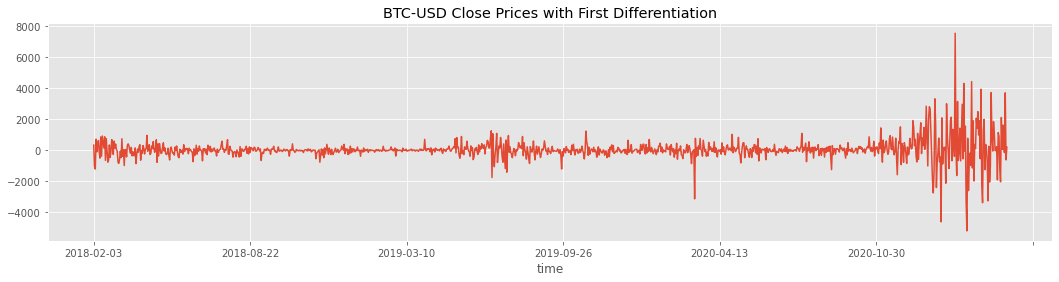

Dickey Fuller Statistical Test      -7.3282
P-value                              0.0000
Used Lags                           19.0000
Number of comments used           1148.0000
Critical Value (1%)                 -3.4361
Critical Value (5%)                 -2.8641
Critical Value (10%)                -2.5681
dtype: float64

In [43]:
#creating a function to plot the graph and show the ADF test result:
def adfuller_test(series, figsize=(18,4), plot=True, title=""):
    if plot:
        series.plot(figsize=figsize, title=title)
        plt.show()
    #Dickey Fuller test on the first differentiation
    adf = adfuller(series)
    output = pd.Series(adf[0:4], index=['Dickey Fuller Statistical Test', 'P-value',
                                        'Used Lags', 'Number of comments used'])
    output = round(output,4)
    
    for key, value in adf[4].items():
        output["Critical Value (%s)"%key] = value.round(4) 
    return output
adfuller_test(df_train.diff().dropna(), title='BTC-USD Close Prices with First Differentiation')

The closing prices become stationary after a first diferentiation of the data.

#### Min Max Scaling

In [44]:
scaler = MinMaxScaler()
df_train_scaled = scaler.fit_transform(df_train.values.reshape(-1,1))
df_train_scaled.shape

(1169, 1)

In [45]:
# Head and tail of scaled dataset
df_train_scaled

array([[0.09357665],
       [0.09918384],
       [0.0818043 ],
       ...,
       [1.        ],
       [0.98978892],
       [0.99305771]])

#### Reshaping

In [46]:
# Transforms the original time series into the input formar required by the LSTM model

nb_timesteps = 3

def makeXy(ts, nb_timesteps, features='itself'): 
    """ 
    Input:  
           ts: original scaled time series 
           nb_timesteps: number of time steps in the regressors 
           features: itself == use the previous values of the label only
                     all == use previous values of all avaialable data
    Output:  
           X: 2-D array of regressors 
           y: 1-D array of target  
   """
    x_train = []
    y_train = []

    for i in range(nb_timesteps, ts.shape[0]):
        if features == 'itself':
            x_train.append(ts[i-nb_timesteps:i,-1])
        else:
            x_train.append(ts[i-nb_timesteps:i, 0:])
        y_train.append(ts[i, -1])

    x_train, y_train = np.array(x_train), np.array(y_train)
    return x_train, y_train 

In [47]:
# Reshape training data into (samples, timestamp, features)

X_train, y_train = makeXy(df_train_scaled, nb_timesteps)
print('Train dataset shape:', X_train.shape, y_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

Train dataset shape: (1166, 3) (1166,)


(1166, 3, 1)

In [48]:
# Reshape validation data
data = pd.concat([df_train, df_val], axis=0)
data.reset_index(inplace=True, drop=True)

val_inputs = data[df_train_scaled.shape[0]-nb_timesteps:].values
#val_inputs.reshape(-1,1)
# Scale validation inputs
val_inputs = scaler.transform(val_inputs.reshape(-1,1))

X_val, y_val = makeXy(val_inputs, nb_timesteps)
print('Train dataset shape:', X_val.shape, y_val.shape)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_val.shape

Train dataset shape: (150, 3) (150,)


(150, 3, 1)

### LSTM Model

In [49]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, InputLayer
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [50]:
# Define LSTM Neural Network
regressor = Sequential()

regressor.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(LSTM(units=200, return_sequences=True, ))
regressor.add(Dropout(rate=0.2))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(rate=0.2))
regressor.add(LSTM(units=75, return_sequences=True))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(rate = 0.2))
regressor.add(Dense(units=1))


regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 200)            161600    
_________________________________________________________________
dropout (Dropout)            (None, 3, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 100)            120400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 75)             52800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 75)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [51]:
# Create directory to save model
!mkdir "keras_models_lstm1D"

In [52]:
# Fit and save best parameters of model
epoch = 100

# Compiler and loss function
regressor.compile(loss='mean_squared_error', optimizer='adam')

# Model Checkpoint
model_folder ='keras_models_lstm1D'
model_file = 'BTC_close_price_lstm_weights.hdf5'
save_weights_at = os.path.join(model_folder, model_file) 
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0, 
                            save_best_only=True, save_weights_only=False, mode='min', 
                            save_freq='epoch') 
# Fit model
regressor.fit(x=X_train, y=y_train, batch_size=32, epochs=epoch, 
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val), 
             shuffle=True) 

Epoch 1/100
37/37 [==============================] - 2s 48ms/step - loss: 0.0281 - val_loss: 0.0072
Epoch 2/100
37/37 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 3/100
37/37 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 4/100
37/37 [==============================] - 0s 8ms/step - loss: 9.7690e-04 - val_loss: 0.0022
Epoch 5/100
37/37 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 6/100
37/37 [==============================] - 0s 10ms/step - loss: 8.5680e-04 - val_loss: 0.0019
Epoch 7/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0036
Epoch 8/100
37/37 [==============================] - 0s 10ms/step - loss: 9.5731e-04 - val_loss: 0.0018
Epoch 9/100
37/37 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 10/100
37/37 [==============================] - 0s 8ms/step - loss: 0.0010 - val_los

In [53]:
regressor.load_weights(model_folder + '\\' + 'BTC_close_price_lstm_weights.hdf5') 
# Validation predict
predicted_price = regressor.predict(X_val)
predicted_price = scaler.inverse_transform(predicted_price)
predicted_price = predicted_price.reshape(X_val.shape[0])

# Train predict
predicted_price_train = regressor.predict(X_train)
predicted_price_train = scaler.inverse_transform(predicted_price_train)
predicted_price_train = predicted_price_train.reshape(X_train.shape[0])

In [54]:
from sklearn.metrics import mean_squared_error
print('Train RMSE:')
print(mean_squared_error(df_train[:df_train.shape[0]-nb_timesteps],predicted_price_train, squared=False))
train_rmse = np.sqrt(np.mean(np.square(df_train[:df_train.shape[0]-nb_timesteps]-predicted_price_train)))
print(train_rmse)

print('Validation RMSE:')
print(mean_squared_error(df_val,predicted_price, squared=False))
test_rmse = np.sqrt(np.mean(np.square(df_val-predicted_price)))
test_rmse

Train RMSE:
569.5296798726037
569.5296798726037
Validation RMSE:
2370.9262103981578


2370.9262103981578

In [55]:
import plotly.express as px
train_results = pd.DataFrame(df_train[:df_train.shape[0]-nb_timesteps])
train_results['train_pred'] = predicted_price_train
px.line(train_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Training data \
        <br><span style="font-size: 13px;color:#444444;">Train RMSE: {:.1f}</span>'.format(train_rmse))

In [56]:
test_results = pd.DataFrame(df_val)
test_results['test_pred'] = predicted_price
px.line(test_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Validation RMSE: {:.1f} </span>'.format(test_rmse))
# plt.figure(figsize=(19,6))
# plt.plot(df_val.index, df_val)
# plt.plot(df_val.index, predicted_price)
# plt.title('BTC-USD Close price prediction - Validation')
# plt.xlabel('Date')
# plt.ylabel('USD')

In [57]:
total_results = pd.concat([train_results,test_results])

px.line(total_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Total data \
        <br><span style="font-size: 13px;color:#444444;">Train RMSE: {:.1f}<br>Validation RMSE: {:.1f} </span>'.format(train_rmse, test_rmse))

In [58]:
blabla = pd.DataFrame(scaler.inverse_transform(val_inputs))
blabla

,0
0,63575.60000
1,62959.23250
2,63156.54500
3,61344.25000
4,60006.76500
...,...
148,46050.37500
149,46391.88125
150,44849.51250
151,45167.90500


In [59]:
X_val

array([[[1.        ],
        [0.98978892],
        [0.99305771]],

       [[0.98978892],
        [0.99305771],
        [0.96303424]],

       [[0.99305771],
        [0.96303424],
        [0.94087673]],

       [[0.96303424],
        [0.94087673],
        [0.87700504]],

       [[0.94087673],
        [0.87700504],
        [0.86830566]],

       [[0.87700504],
        [0.86830566],
        [0.88161216]],

       [[0.86830566],
        [0.88161216],
        [0.83790228]],

       [[0.88161216],
        [0.83790228],
        [0.80312467]],

       [[0.83790228],
        [0.80312467],
        [0.79345718]],

       [[0.80312467],
        [0.79345718],
        [0.77572808]],

       [[0.79345718],
        [0.77572808],
        [0.75981479]],

       [[0.77572808],
        [0.75981479],
        [0.84131482]],

       [[0.75981479],
        [0.84131482],
        [0.8581538 ]],

       [[0.84131482],
        [0.8581538 ],
        [0.8552383 ]],

       [[0.8581538 ],
        [0.8552383 ],
    

In [60]:
val_inputs

array([[1.        ],
       [0.98978892],
       [0.99305771],
       [0.96303424],
       [0.94087673],
       [0.87700504],
       [0.86830566],
       [0.88161216],
       [0.83790228],
       [0.80312467],
       [0.79345718],
       [0.77572808],
       [0.75981479],
       [0.84131482],
       [0.8581538 ],
       [0.8552383 ],
       [0.83403801],
       [0.90256581],
       [0.90435459],
       [0.88401269],
       [0.89378521],
       [0.8277872 ],
       [0.89820185],
       [0.88109393],
       [0.89625564],
       [0.92193759],
       [0.91167077],
       [0.87144562],
       [0.88574435],
       [0.76829858],
       [0.76970776],
       [0.77258791],
       [0.72131986],
       [0.7158488 ],
       [0.66805991],
       [0.65675983],
       [0.55416427],
       [0.61802782],
       [0.56397311],
       [0.56720109],
       [0.52122097],
       [0.58960458],
       [0.58168314],
       [0.5968342 ],
       [0.5850416 ],
       [0.5376262 ],
       [0.52004189],
       [0.537